In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import networkx as nx
import time

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)
# local functions
import diffusionNMF
import grid_search
import data_generator
import nmf
from diffusionNMF import diffusionNMF
from grid_search import gridSearcher
from data_generator import gen_decomposition, gen_laplacian
from nmf import nmf

%load_ext autoreload
%autoreload 2

In [2]:
sns.set_theme()

### Generate synthetic data

In [53]:
# defined parameters for data
n = 250
m = 50
rank = 4
rand_state = 1729

In [54]:
W,H = gen_decomposition(n,m,rank,state=rand_state)

Text(0.5, 1.0, 'Sparse H')

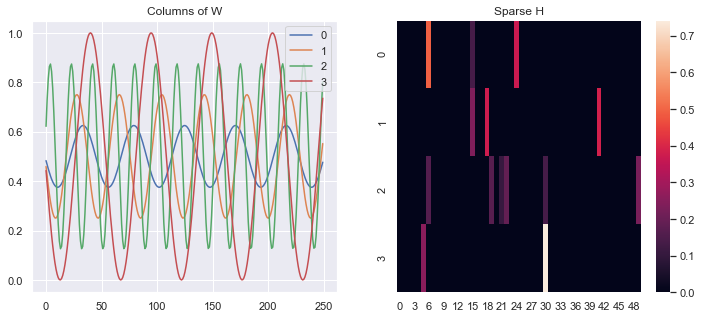

In [55]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
W.plot(ax=ax[0])
ax[0].set_title("Columns of W")
sns.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Sparse H")

In [18]:
# calculate sparseness of H
# based on the hoyer definition of sparseness
def h_sparseness(h):
    h_sparse = 0
    for row in h.index:
        rh = np.array(h.loc[row,:])
        sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
        sp /= (math.sqrt(len(rh)) - 1)
        h_sparse += sp
    
    h_sparse /= len(h.index)
    
    return h_sparse

In [19]:
h_sparse = h_sparseness(H)
h_sparse

0.9020156637379071

In [20]:
G, lapl = gen_laplacian(size = m, H = H, p_edge = 0.1, state = rand_state)

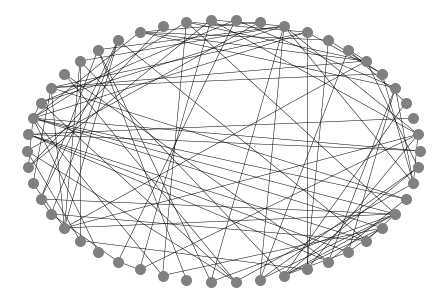

In [21]:
colors = [G[i][j]['color'] for i,j in G.edges()]
widths = [G[i][j]['width'] for i,j in G.edges()]
nx.draw_circular(G, edge_color=colors, width=widths, node_size=100,node_color='gray')

### Initial Test

In [22]:
beta = 1
I = np.identity(np.dot(W,H).shape[1])
#state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()
K = np.linalg.inv(I + beta*lapl)
D = np.dot(W, np.dot(H,K))

<AxesSubplot:>

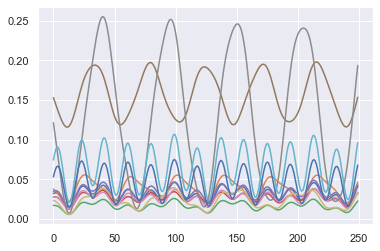

In [23]:
P = pd.DataFrame(D)
P.loc[:,10:20].plot(legend=False)

In [24]:
nmfer = nmf(n_components = 4, mask = None, n_iter = 100000, tol = 1e-9)
W_out, H_out = nmfer.fit_transform(D)

Text(0.5, 1.0, 'reconstructed H')

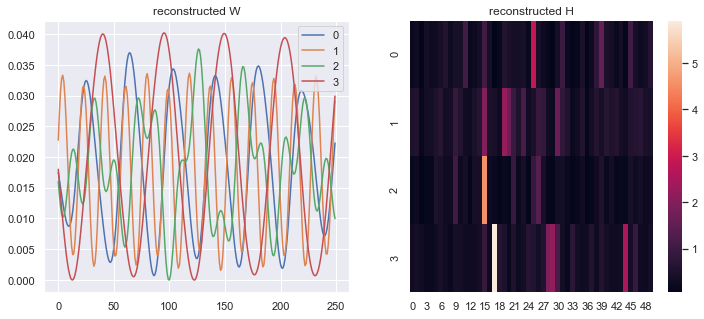

In [25]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
pd.DataFrame(W_out).plot(title = "reconstructed W", ax = ax[0])
sns.heatmap(H_out, square = False, cbar = True, ax = ax[1])
ax[1].set_title("reconstructed H")

In [26]:
differ = diffusionNMF(n_components = 4, kernel = K, mask = None, n_iter = 100000, tol = 1e-9)

In [27]:
X,V = differ.fit_transform(D)

Text(0.5, 1.0, 'reconstructed V')

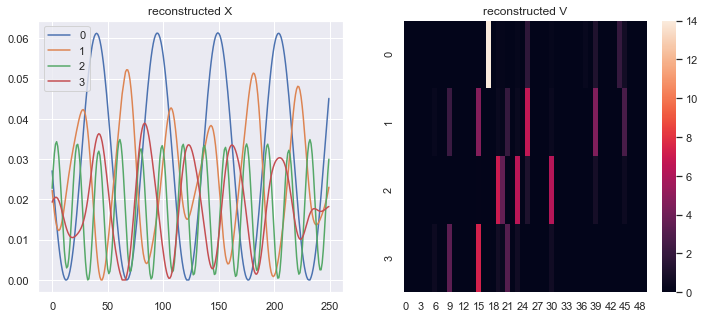

In [28]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
pd.DataFrame(X).plot(title = "reconstructed X", ax = ax[0])
sns.heatmap(V, square = False, cbar = True, ax = ax[1])
ax[1].set_title("reconstructed V")

Text(0.5, 1.0, 'Random Subset of Reconstructed Matrix')

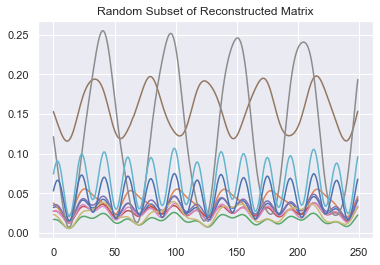

In [29]:
res = pd.DataFrame(X @ V @ K)
#rand_assort = random.choices(list(range(len(res.columns))), k = 10)
#res.plot(y = rand_assort)
res.loc[:,10:20].plot(legend = False)
plt.title("Random Subset of Reconstructed Matrix")

### Adding Noise

In [30]:
def noiser(matr, std_dev = None):
    # add noise to a matrix using gaussian random samples
    matr = np.matrix.copy(matr)
    if std_dev is None:
        std_dev = matr.std() / 100

    for rower in range(matr.shape[0]):
        for coler in range(matr.shape[1]):
            noisy = np.random.normal(scale = std_dev)
            if matr[rower, coler] + noisy < 0:
                matr[rower, coler] = 0
            else:
                matr[rower, coler] += noisy
    
            
    return matr

Text(0.5, 1.0, 'Subset of Data with Noise added')

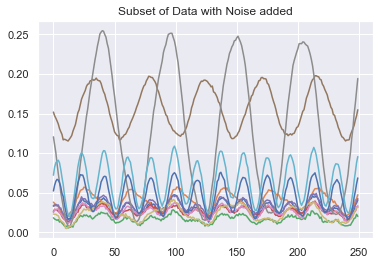

In [31]:
noise_D = noiser(D, 0.001)
pd.DataFrame(noise_D).loc[:,10:20].plot(legend=False)
plt.title("Subset of Data with Noise added")

### Hiding entries

In [32]:
# Creates a matrix of 0s -- unknown values -- and 1's -- known values ---
# in order to "mask" the data and split it into train/test sets
def train_mask(data, percent_hide):
    # "hide" a given percentage of the data
    num_entries = data.shape[0]*data.shape[1]
    mask = np.zeros(num_entries)
    mask[:int(num_entries * (1 - percent_hide))] = 1
    np.random.shuffle(mask)
    mask = mask.reshape(data.shape)
    
    return mask

In [33]:
hidden_mask = train_mask(noise_D, 0.2)

### Error Baseline

In [56]:
def ground_error(data, tests, n_avg = 10, noise_base = 0.001, percent_hide = 0.2):
    ground_error = np.zeros(tests)
    ground_std = np.zeros(tests)
    
    for t in range(tests):
        g_err = np.zeros(n_avg)
        for n in range(n_avg):
            noise_D = noiser(data, noise_base)
            hidden_mask = train_mask(noise_D, 0.2)
            g_err[n] = np.linalg.norm((1 - hidden_mask) * (noise_D - data)) / np.linalg.norm((1 - hidden_mask) * data)
            
        ground_error[t] = g_err.mean()
        ground_std[t] = g_err.std()
        
    return ground_error, ground_std

In [57]:
rank = 4
beta = 1
noise_base = 0.001
W,H = gen_decomposition(n, m, rank, state = rand_state)
G, lapl = gen_laplacian(size = m, H = H, p_edge = 0.05, state = rand_state)
K = np.linalg.inv(I + beta*lapl)
D = np.dot(W, np.dot(H, K))

In [58]:
# Holding true rank at 4:
ranks = list(range(1,15))
betas = np.array([1])
n_avg = 10

ground, ground_std = ground_error(D, len(ranks), n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)

nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
nmf_res = nG.grid_search(ranks, betas)

dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
diff_res = dG.grid_search(ranks, betas)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 28.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 33.0min finished


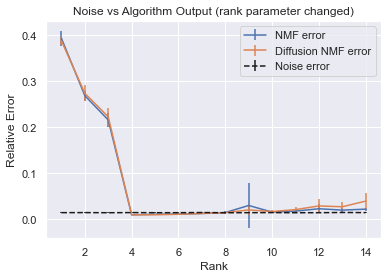

In [63]:
ranks = list(range(1,15))
plt.errorbar(ranks, nmf_res["relative error"], nmf_res["std error"], label = "NMF error")
plt.errorbar(ranks, diff_res["relative error"], diff_res["std error"], label = "Diffusion NMF error")
plt.errorbar(ranks, ground, ground_std, color = "k", linestyle = "--", label = "Noise error")
plt.xlabel("Rank")
plt.ylabel("Relative Error")
plt.title("Noise vs Algorithm Output (rank parameter changed)")
plt.legend()

In [64]:
# Holding true beta at 1:
ranks = [4]
betas = np.linspace(0.01,2,15)
n_avg = 10

ground2, ground_std2 = ground_error(D, len(betas), n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)

nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
nmf_res2 = nG.grid_search(ranks, betas)

dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
diff_res2 = dG.grid_search(ranks, betas)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.6min finished


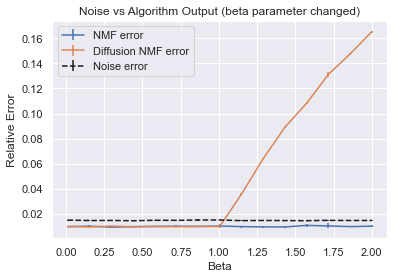

In [66]:
plt.errorbar(betas, nmf_res2["relative error"], nmf_res2["std error"], label = "NMF error")
plt.errorbar(betas, diff_res2["relative error"], nmf_res2["std error"], label = "Diffusion NMF error")
plt.errorbar(betas, ground2, ground_std2, color = "k", linestyle = "--", label = "Noise error")
plt.xlabel("Beta")
plt.ylabel("Relative Error")
plt.title("Noise vs Algorithm Output (beta parameter changed)")
plt.legend()

In [46]:
beta = 1
rank_tests = range(1,15)
ground3 = np.zeros(len(rank_tests))
nmf_res3 = np.zeros(len(rank_tests))
diff_res3 = np.zeros(len(rank_tests))
n_avg = 10

for r in rank_tests:
    W,H = gen_decomposition(n, m, r, state = rand_state)
    G, lapl = gen_laplacian(size = m, H = H, p_edge = 0.05, state = rand_state)
    K = np.linalg.inv(I + beta * lapl)
    D = np.dot(W, np.dot(H,K))
    
    ranks = [r]
    betas = [beta]
    
    g_err = ground_error(D, len(ranks), n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)
    ground3[r - 1] = g_err

    nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
    n_err = nG.grid_search(ranks, betas)
    nmf_res3[r - 1] = n_err.loc[0, "relative error"]
    
    dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
    d_err = dG.grid_search(ranks, betas)
    diff_res3[r - 1] = d_err.loc[0, "relative error"]
    

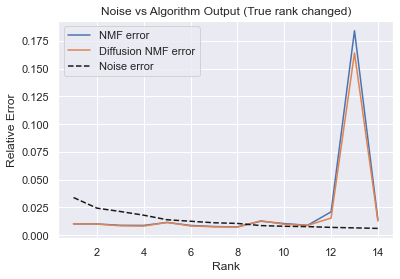

In [47]:
plt.plot(rank_tests, nmf_res3, label = "NMF error")
plt.plot(rank_tests, diff_res3, label = "Diffusion NMF error")
plt.plot(rank_tests, ground3, "k--", label = "Noise error")
plt.xlabel("Rank")
plt.ylabel("Relative Error")
plt.title("Noise vs Algorithm Output (True rank changed)")
plt.legend()

In [48]:
rank = 4
beta_tests = np.linspace(0.1,2,15)
ground4 = np.zeros(len(beta_tests))
nmf_res4 = np.zeros(len(beta_tests))
diff_res4 = np.zeros(len(beta_tests))
n_avg = 10

for b in range(len(beta_tests)):
    W,H = gen_decomposition(n, m, rank, state = rand_state)
    G, lapl = gen_laplacian(size = m, H = H, p_edge = 0.05, state = rand_state)
    K = np.linalg.inv(I + beta_tests[b] * lapl)
    D = np.dot(W, np.dot(H,K))
    
    ranks = [rank]
    betas = [beta_tests[b]]
    
    g_err = ground_error(D, 1, n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)
    ground4[b] = g_err

    nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
    n_err = nG.grid_search(ranks, betas)
    nmf_res4[b] = n_err.loc[0, "relative error"]
    
    dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
    d_err = dG.grid_search(ranks, betas)
    diff_res4[b] = d_err.loc[0, "relative error"]

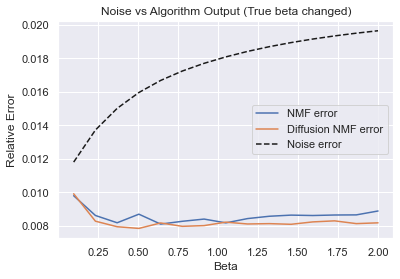

In [49]:
plt.plot(beta_tests, nmf_res4, label = "NMF error")
plt.plot(beta_tests, diff_res4, label = "Diffusion NMF error")
plt.plot(beta_tests, ground4, "k--", label = "Noise error")
plt.xlabel("Beta")
plt.ylabel("Relative Error")
plt.title("Noise vs Algorithm Output (True beta changed)")
plt.legend()

### Grid Search

In [62]:
t_data = pd.read_csv("./testing_data/grid_search_4_1.csv", index_col = 0)

In [63]:
t_data = t_data[t_data["relative error"] <= 0.05]

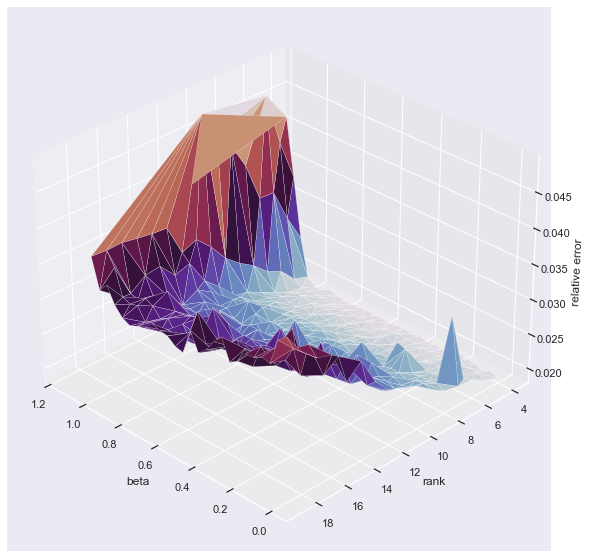

In [64]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(t_data['beta'], t_data['rank'], t_data['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,135)

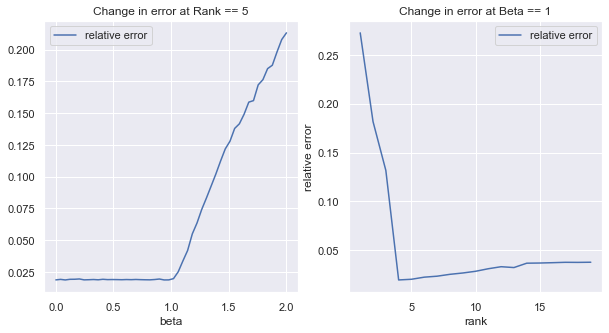

In [9]:
t_rank = t_data.loc[t_data["rank"] == 4]
f = t_data[t_data["beta"] >= 1].iloc[0]["beta"]
t_beta = t_data.loc[t_data["beta"] == f]

fix, ax = plt.subplots(1,2,figsize = (10,5))
t_rank.plot(x="beta", y="relative error", ax = ax[0])
ax[0].set_title("Change in error at Rank == 4")
t_beta.plot(x="rank", y="relative error", ax = ax[1])
ax[1].set_title("Change in error at Beta == 1")
plt.ylabel("relative error")
plt.legend()

In [65]:
g_4_10 = pd.read_csv("./testing_data/grid_search_4_10_small.csv", index_col = 0)  

In [66]:
g_4_10 = g_4_10[g_4_10["relative error"] <= 0.05]

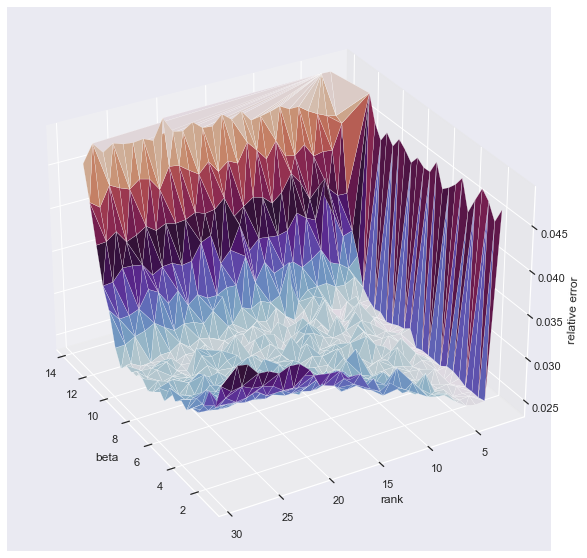

In [67]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(g_4_10['beta'], g_4_10['rank'], g_4_10['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

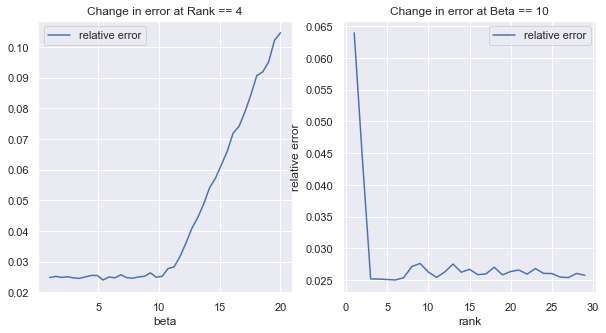

In [14]:
g_rank = g_4_10.loc[g_4_10["rank"] == 4]
f = g_4_10[g_4_10["beta"] >= 10].iloc[0]["beta"]
g_beta = g_4_10.loc[g_4_10["beta"] == f]

fix, ax = plt.subplots(1,2,figsize = (10,5))
g_rank.plot(x="beta", y="relative error", ax = ax[0])
ax[0].set_title("Change in error at Rank == 4")
g_beta.plot(x="rank", y="relative error", ax = ax[1])
ax[1].set_title("Change in error at Beta == 10")
plt.ylabel("relative error")
plt.legend()

In [50]:
grid_4_10 = pd.read_csv("./testing_data/grid_search_4_10.csv", index_col = 0) 

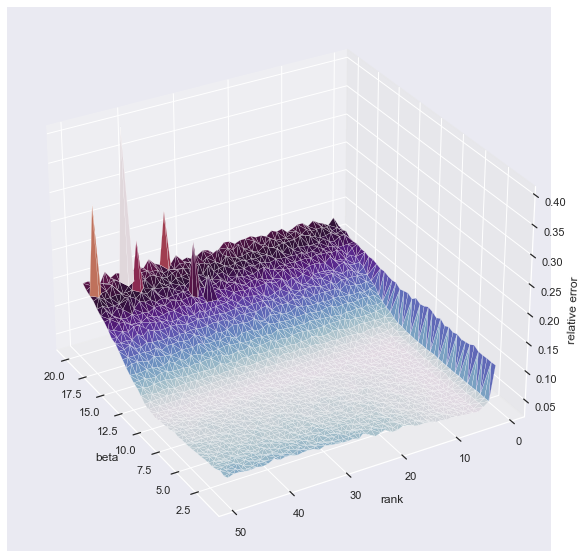

In [51]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(grid_4_10['beta'], grid_4_10['rank'], grid_4_10['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

In [10]:
grid_4_20 = pd.read_csv("./testing_data/grid_search_4_20.csv", index_col = 0)

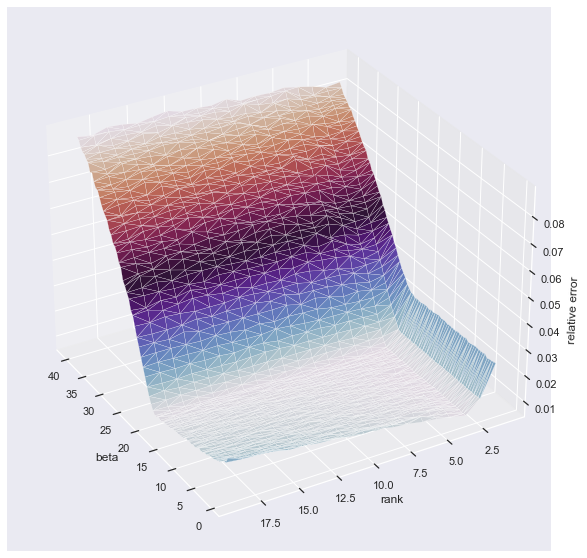

In [11]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(grid_4_20['beta'], grid_4_20['rank'], grid_4_20['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

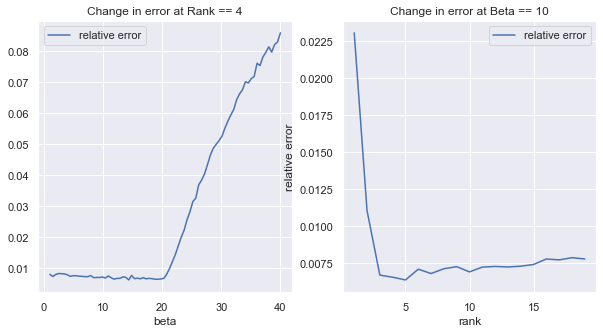

In [17]:
gr_rank = grid_4_20.loc[grid_4_20["rank"] == 4]
f = grid_4_20[grid_4_20["beta"] >= 20].iloc[0]["beta"]
gr_beta = grid_4_20.loc[grid_4_20["beta"] == f]

fix, ax = plt.subplots(1,2,figsize = (10,5))
gr_rank.plot(x="beta", y="relative error", ax = ax[0])
ax[0].set_title("Change in error at Rank == 4")
gr_beta.plot(x="rank", y="relative error", ax = ax[1])
ax[1].set_title("Change in error at Beta == 10")
plt.ylabel("relative error")
plt.legend()